In [61]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id
import torchvision.transforms as T
import requests
import io
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from PIL import Image
# Util function for loading point clouds|
import numpy as np
from tqdm import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from midas_utils import midas
from detic_utils import detic

def plot_image(image, mask_fg, depth):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[1].imshow(mask_fg)
    axs[1].axis('off')
    axs[2].imshow(depth)
    axs[2].axis('off')
    plt.show()


def render_pose(point_cloud, elev = 0, azim = 0, resolution = 512, use_persp=False):
    R, T = look_at_view_transform(dist=2, elev=elev, azim=azim)
    if use_persp: cameras = FoVPerspectiveCameras(device='cuda', R=R, T=T, znear=0.01)
    else: cameras = FoVOrthographicCameras(device='cuda', R=R, T=T, znear=0.01)
    raster_settings = PointsRasterizationSettings(
        image_size=resolution, 
        radius = 0.008,
        points_per_pixel = 10,
        #bin_size = None
    )
    
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)

    # Create a points renderer by compositing points using an weighted compositor (3D points are
    # weighted according to their distance to a pixel and accumulated using a weighted sum)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor()#NormWeightedCompositor()
    )
    
    depth_map = rasterizer.transform(point_cloud).points_packed()
    depth_map = (depth_map+1)/2
    features = point_cloud.features_packed()
    features[:,0] = 0 #depth_map[:,0]
    features[:,1] = 0#depth_map[:,1]
    features[:,2] = 1-depth_map[:,2]
    point_cloud = Pointclouds(points = [point_cloud.points_packed()], features=[features[:,2]])
    images = renderer(point_cloud)
    output = images[0, ..., :3].cpu().numpy()
    return output

def plot_views(views):
    blk = 5
    fig, axs = plt.subplots(blk, blk, figsize=(20, 20))
    for i, view in enumerate(views):
        axs[blk-1-(i//blk), i%blk].imshow(view)
    plt.show()

# TODO: center 
#mu_x, mu_y, mu_z = *np.argwhere(mask_fg).mean(axis=0), depth_fg.mean()
#mu_x, mu_y = mu_x / mask_fg.shape[0], mu_y / mask_fg.shape[1]
#tau_xy, tau_z = np.max([np.abs(mu_x), np.abs(1-mu_x), np.abs(mu_y), np.abs(1-mu_y)]), np.abs(depth_fg - mu_z).max()
#point_cloud = torch.Tensor([[[(j/m-mu_x)/tau_xy,(i/n-mu_y)/tau_xy,depth[i,j]] for j in range(m)] for i in range(n)])[mask_fg].reshape((-1, 3)).cuda()

def render_multiple_views(image, mask_fg, depth, N = 100, resolution = 512, use_persp=False):
    depth_fg = depth[mask_fg]
    mu_z = depth_fg.mean()
    tau_z = np.abs(depth_fg - mu_z).max()
    depth = (depth-mu_z)/tau_z
    n, m = depth.shape
    idxs = np.argwhere(mask_fg)
    y, x = (idxs.min(axis=0) + idxs.max(axis=0))/2
    y, x = y/mask_fg.shape[0], x / mask_fg.shape[1]
    point_cloud = torch.Tensor([[[2*(j/m-x),-2*(i/n-y),depth[i,j]] for j in range(m)] for i in range(n)])[mask_fg].reshape((-1, 3)).cuda()
    pixel_features = torch.Tensor((1+depth[mask_fg])/2).reshape(-1,1).repeat(1,3).cuda()
    point_cloud = Pointclouds(points=[point_cloud], features=[pixel_features])
    
    blk = 5
    rng_e, rng_a = 30, 60
    assert(N%(blk*blk) == 0)
    B = N // (blk*blk)
    ext_e, ext_a = rng_e/(blk-1), rng_a/(blk-1)
    azims = np.random.uniform(-ext_a, ext_a, B*blk*blk)
    elevs = np.random.uniform(-ext_e, ext_e, B*blk*blk)
    #return [render_pose(point_cloud, elev=elevs[i], azim=azims[i], resolution=resolution, use_persp=False) for i in tqdm(range(N), position=0, leave=True)]
    viewpoints = np.array([[(2*i-blk+1)*ext_e+elevs[(b*blk+i)*blk+j], (2*j-blk+1)*ext_a+azims[(b*blk+i)*blk+j]]  for i in range(blk) for j in range(blk) for b in range(B)])
    return [render_pose(point_cloud, elev=elev, azim=azim, resolution=resolution, use_persp=use_persp) for elev, azim in viewpoints], viewpoints, point_cloud

def plot_pointcloud(pixel_point_cloud):
    fig = plot_scene({
        "pixel": {
            "object": pixel_point_cloud,
        },
        #"depth": {
        #    "object": depth_point_cloud
        #},
    }, axis_args=AxisArgs(backgroundcolor="rgb(0,0,0)"), pointcloud_marker_size=0.5, ncols=2) #, viewpoint_cameras=) # kwarg axis_args
    fig.show()

car:   0%|                                                                                                                                           | 0/2000 [00:00<?, ?it/s]

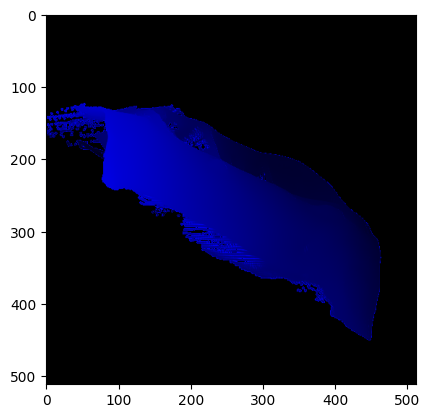

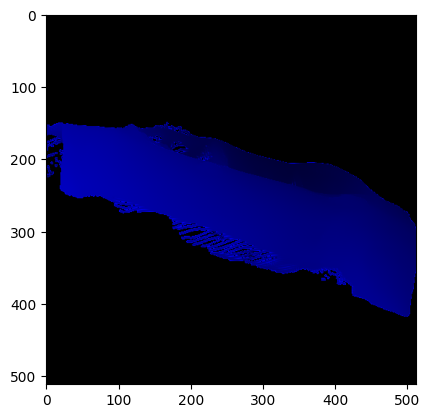

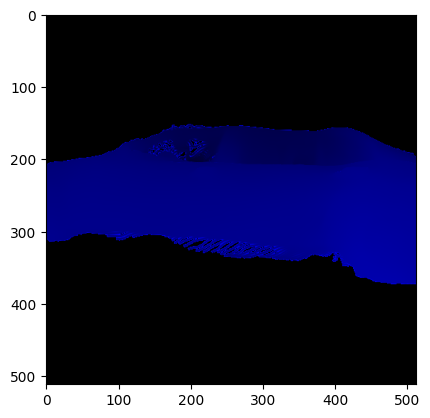

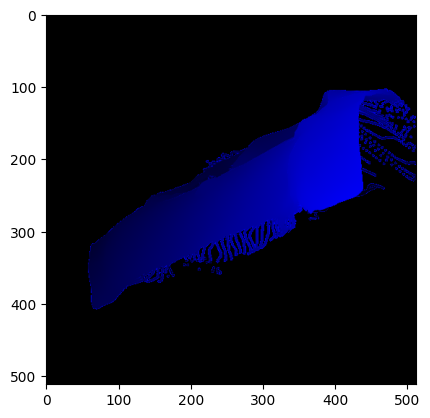

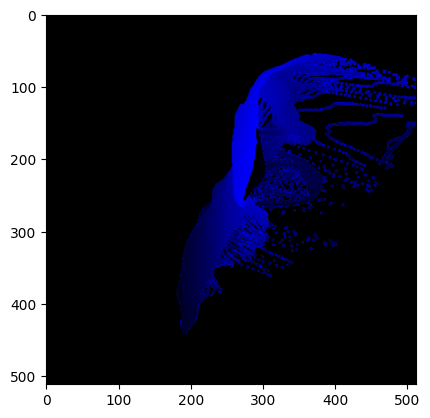

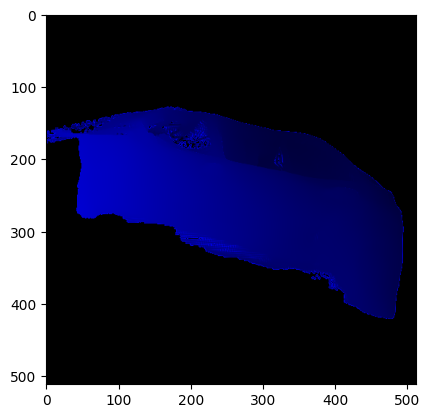

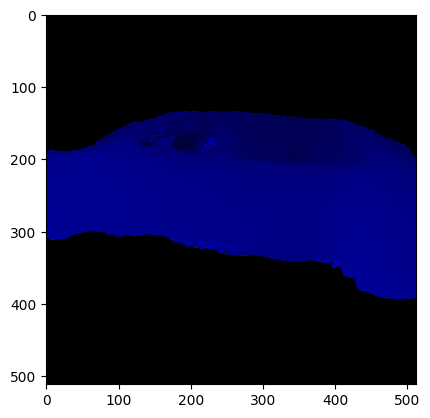

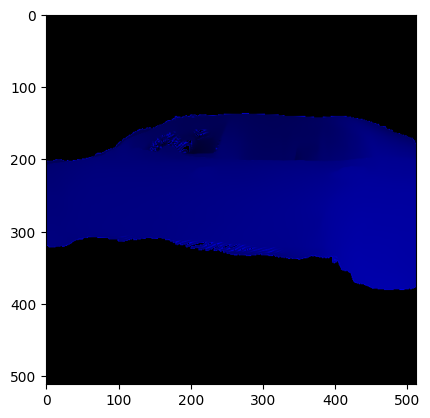

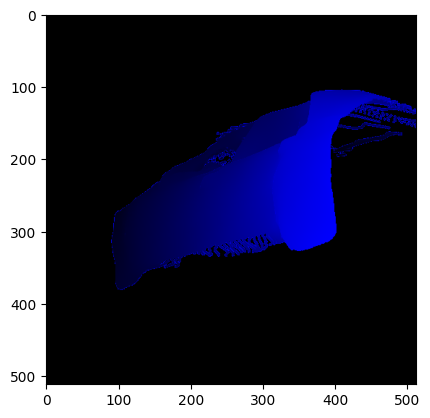

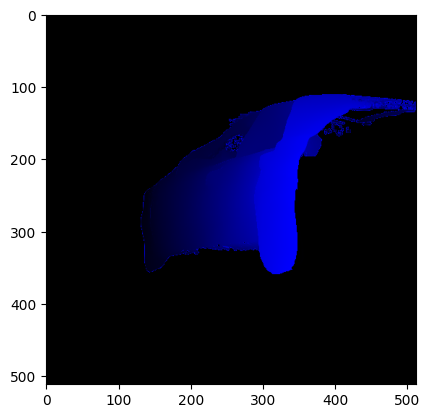

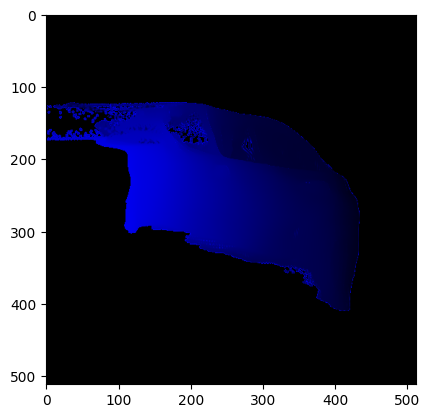

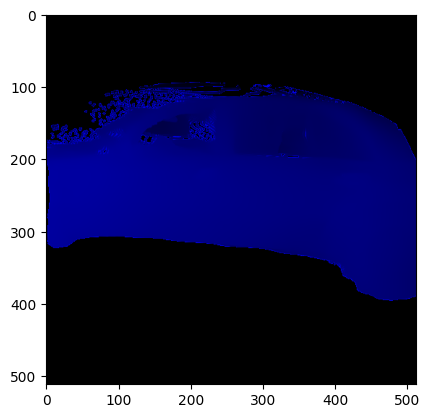

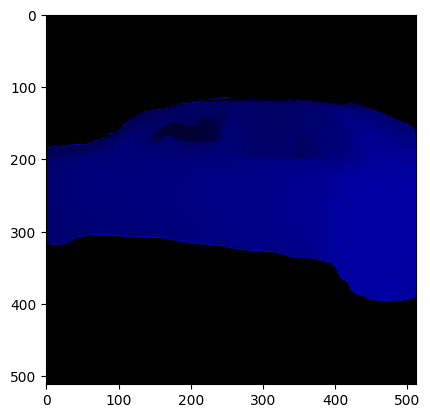

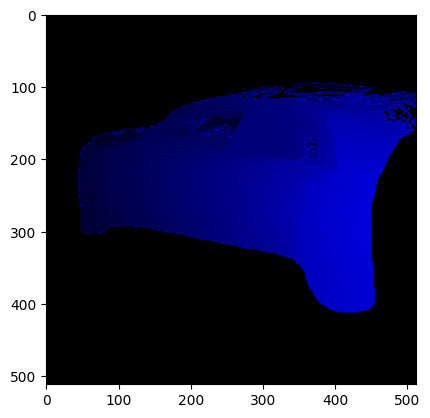

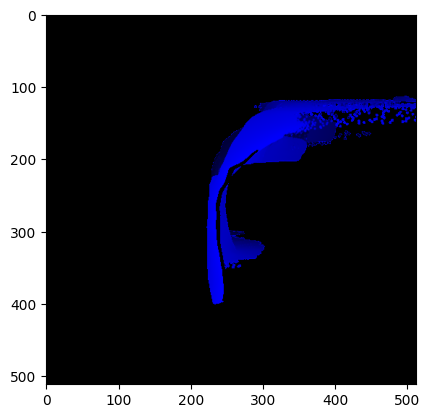

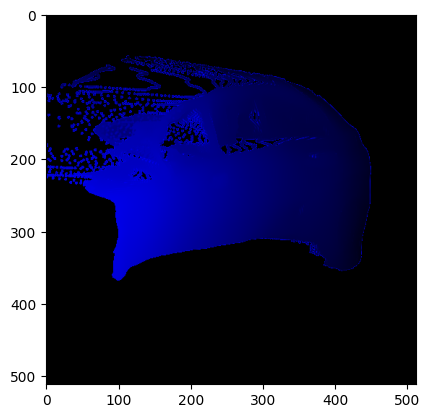

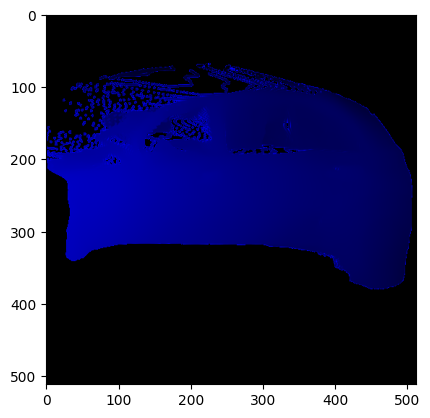

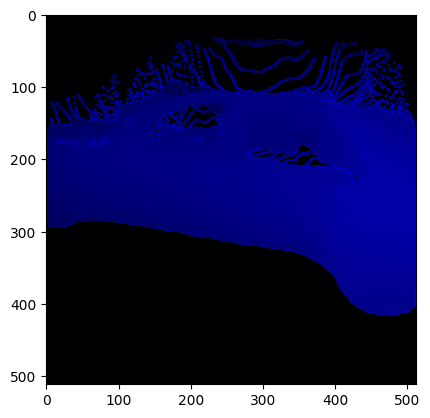

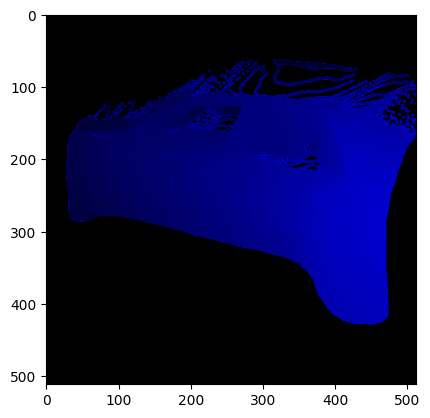

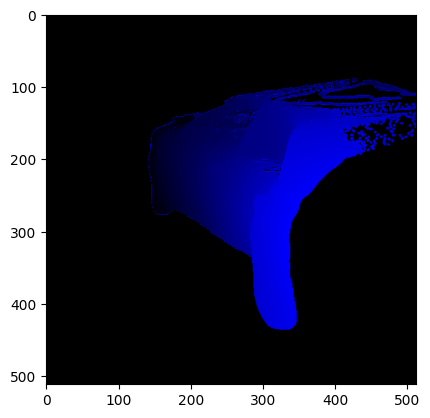

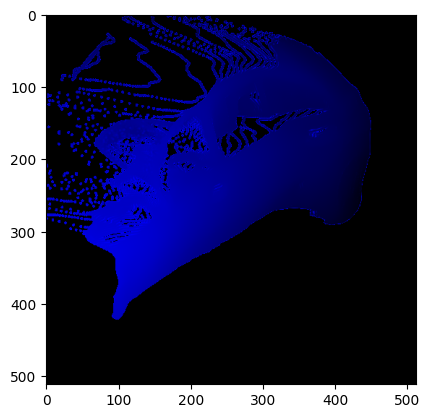

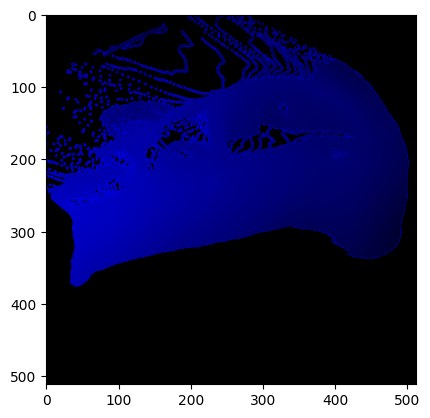

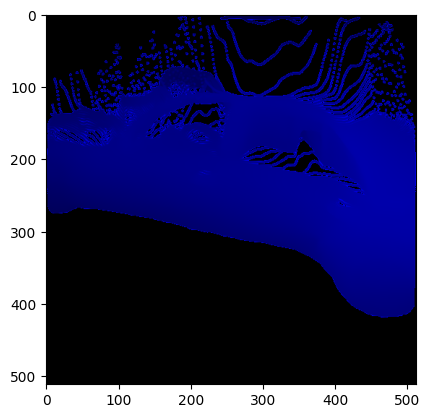

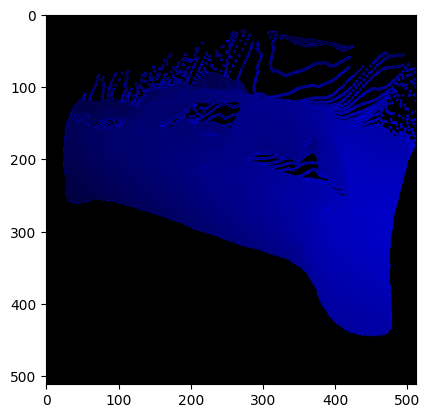

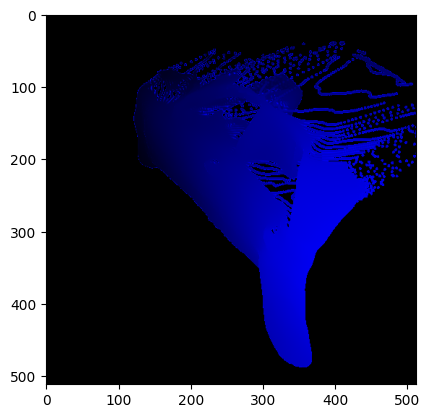

car:   0%|                                                                                                                                           | 0/2000 [00:03<?, ?it/s]


In [62]:
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import cv2
import pandas as pd

'''
Paths
'''
data_path = '/grogu/user/akirchme/art3d_sd_webui'
classes = ['horse', 'dog', 'bird', 'car']
n_views = 25
cls = 'car'
'''
Generate multiple viewpoints
'''
files = sorted([f for f in listdir(f'{data_path}/fg/{cls}') if isfile(join(f'{data_path}/fg/{cls}', f))])
for file in tqdm(files, desc=cls):
    file_id = file.split('.')[0]
    img_path, mask_path = f'{data_path}/fg/{cls}/{file_id}.png', f'{data_path}/masks/{cls}/{file_id}.npy'
    image = np.array(Image.open(img_path).convert('RGB'))
    #mask_fg = detic(image, cls, mode='cls') == 1 if not os.path.exists(mask_path) else np.load(mask_path)
    mask_fg = np.load(mask_path)
    depth = midas(Image.fromarray(image, 'RGB'))
    depth[~mask_fg] = 0

    views, viewpoints, _ = render_multiple_views(image, mask_fg, depth, N=n_views, use_persp=False)
    #views, pc = render_multiple_views(image, mask_fg, depth, N=n_views, use_persp=True)
    #plot_views(views)
    #plot_pointcloud(pc) 
    for i, view in enumerate(views):
        view = (255*view).astype(np.uint8)
        plt.imshow(view)
        plt.show()
    break